# adexdSTRF twin experiment

This script runs a twin experiment with a dSTRF model composed of the augmented adexmodel and a cosine basis STRF.

In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
from models import cosstrf, adex, adex_zero_centered, dstrf_adex

from neurofit import utils as nfutils


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

rcParams["svg.fonttype"]='none'
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

## Setting paramters and loading data

In [2]:
# assimilation parameters
nwalkers = 1000
burn = 1000
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# dstrf model settings
free_ts = False
scale = 5
channels = 1
ncos = 10
coslin = 1
norm = True
center = True

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

stims,durations = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)[:2]

## Simulating data for the twin experiment

### Building the STRF

/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


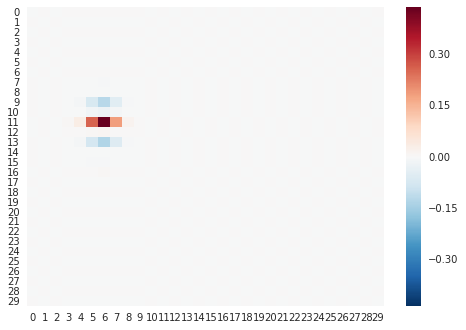

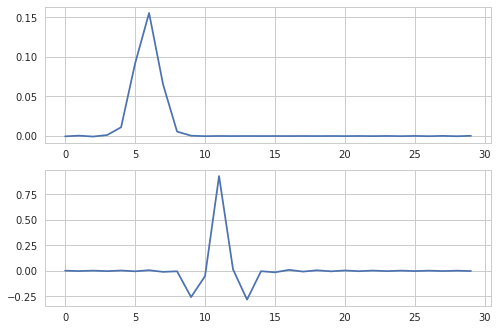

In [3]:
filts = np.load('../filters.npz')
k = resample(resample(filts['nbs'],nspec,axis=0),tlen,axis=1)
#k = nfutils.normalize(k,center=False)

figure()
sns.heatmap(k,linewidths = 0)

figure()
B = np.sum(k,axis=1)
A = np.sum(k,axis=0)
subplot(211)
plot(A)
subplot(212)
plot(B)

# create cosine basis for time dimension
spec,tim = utils.factorize(k)
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True)
costim = tot(tim)
 
# set adexmodel parameters
matparam  = [10,2,0,8]
#matparam  = [20,2,0,25]

In [4]:
# set adexmodel parameters
matlabs = ['gl','delt','vt','tw','a','vr','b','h']
adexparam  = [0.5, 1.0, 10, 50, 1, -10, 10]

dataparam = np.hstack((spec[0],costim[0],adexparam))
M = dstrf_adex(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center)
M.set(dataparam)

### Generating noisy data

In [5]:
# data settings
ntrials = 5
noise = 0.25
dataparam = np.hstack((spec[0],costim[0],adexparam))
M = dstrf_adex(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,noise=noise,normalize=norm,center=center)
M.set(dataparam)

# generate the data
spikes_data = []
spiky_data = []
binary_data = []
model_data   = []
for s,dur in zip(stims,durations):
    dsdur = int(dur/t_dsample)
    sr = []
    sspk = []
    s0 = []
    sspiky = []
    for n in range(ntrials):
        z = np.zeros(dur,dtype=int)
        r,spikes = M.run(s)
        z[spikes] = 1
        sr.append(r)
        sspk.append(spikes)
        sspiky.append(pyspk.SpikeTrain(spikes,[0,dur]))
        s0.append(z)
    model_data.append(sr)
    spikes_data.append(sspk)
    spiky_data.append(sspiky)
    binary_data.append(s0)
psth_data = [utils.psth_spiky(spk,smooth=psth_smooth,dsample=t_dsample) for spk,st in zip(spiky_data,stims)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=t_dsample) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.83


## Getting initial guess for STRF

In [6]:
# estimate STRF using elastic net regression
fit_psth = [p*1000 for p in assim_psth]
#fit_psth = [np.log(p*1000 + 1) for p in assim_psth]

STRF_GUESS, B_GUESS = utils.get_strf(assim_stims,fit_psth,tlen,fit_intercept=False)
SPEC,TIM = utils.factorize(STRF_GUESS,1)

# create initial paramter vector from estimated strf
filt_start = np.hstack((SPEC,tot(TIM))).flatten()

/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.58990494345


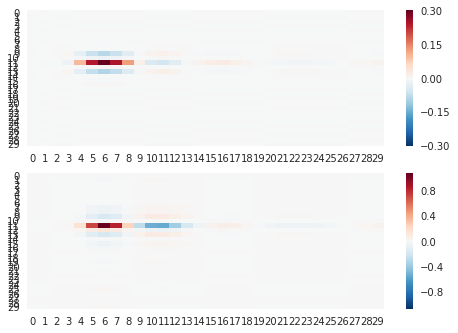

In [7]:
# plot true and estimated strf
subplot(211)
sns.heatmap(M.pstrf.filt)

subplot(212)
strf_model = cosstrf(channels,nspec,tlen,ncos,coslin,normalize=norm,center=center)
strf_model.set(filt_start)
sns.heatmap(strf_model.filt)

print(utils.evaluate(strf_model.filt,test_stims,test_psth))

## Define loss and prior functions

In [8]:
from neurofit import priors
from neurofit import costs

def spike_distance(predict,data):
    trace, spikes = predict
    spiky = pyspk.SpikeTrain(spikes,[0,data[0].t_end])
    dist = 1000*np.mean([pyspk.spike_distance(spiky,trial) for trial in data])
    return dist


adex_prior = priors.joint_independent(
              [priors.uniform(   0,  1),
                priors.uniform( 0.5,  2),
                priors.uniform(  0,   30),
                priors.uniform(   1, 200),
                priors.uniform( -10,  10),
                priors.uniform( -30,  30),
                priors.uniform(   0,  50)])

cost = spike_distance
unbounded = priors.unbounded()

def dstrf_shrink_prior(theta):
    return -np.sum(np.abs(theta[:-7])) + adex_prior(theta[-7:])


## Run initial adexparameter fit

In [9]:
from neurofit import startpos

burn = 500

# get I with STRF fixed
Iapp = []
for s,dur in zip(stims,durations):
    R = resample(strf_model.run(s),dur)
    Iapp.append(R*scale)
    
assim_Iapp, test_Iapp = np.split(Iapp,[num_assim_stims])

# initalize the adexmodel
adex_model = adex_zero_centered()

init = [0.5, 2.0, 20, 50, 1, -10, 15]
#init=mml
p0 = startpos.normal_independent(nwalkers,init,[0.01]*7)

# run emcee
adex_smplr = nf.sampler(adex_model,adex_prior,cost,nwalkers,zip(assim_Iapp,assim_spiky),threads)

for pos,_,_ in tracker(adex_smplr.sample(p0,iterations=burn)): continue
adex_smplr.reset()
adex_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------


/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


   100     -1665.8     0:00:52     0:08:01
   200     -1589.9     0:01:46     0:07:09
   300     -1460.6     0:02:40     0:06:15
   400     -1447.1     0:03:32     0:05:19
   500     -1441.2     0:04:22     0:04:23


In [10]:
# check the performance of the fit adexmodel
mml = adex_smplr.flatchain[np.argmax(adex_smplr.flatlnprobability)]
mml = adexparam
adex_map = adex_zero_centered()
adex_map.set(mml)
adex_corr = []

param_corr = utils.evaluate(STRF_GUESS,test_stims,test_psth)

for i,p,d in zip(test_Iapp,test_psth,test_dur):
    trace,spikes = adex_map.run(i)
    adex_psth = utils.psth_spiky(pyspk.SpikeTrain(spikes,[0,d]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    adex_corr.append(np.corrcoef(p,adex_psth)[0][1])
        
start = np.hstack((filt_start,mml))
print("Filt R: {:.3f}, adexR: {:.3f}".format(param_corr,np.mean(adex_corr)))

Filt R: 0.588, adexR: 0.577


## Fit dSTRF model using emcee

In [11]:
# initalize the model
model = dstrf_adex(channels,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center)

p0 = startpos.normal_independent(nwalkers-1,start,[1e-4]*len(start))
p0 = np.vstack((start,p0))


# run emcee
dstrf_smplr = nf.sampler(model,dstrf_shrink_prior,spike_distance,nwalkers,zip(assim_stims,assim_spiky),threads)
for pos,_,_ in tracker(dstrf_smplr.sample(p0,iterations=burn)): continue
dstrf_smplr.reset()
dstrf_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -1347.7     0:04:11     0:38:11
   200     -1122.5     0:08:27     0:34:02
   300     -1089.6     0:12:42     0:29:47
   400     -1069.6     0:17:00     0:25:37
   500     -1052.2     0:21:41     0:21:47


## Evaluate the model fit

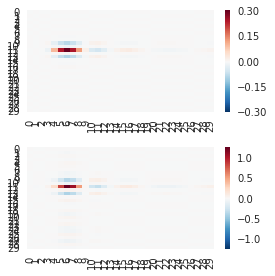

In [12]:
# initalize model with MAP parameter estimate
dmap = dstrf_smplr.flatchain[np.argmax(dstrf_smplr.flatlnprobability)]
model.set(dmap)

figure(figsize=(4,4))
# compare true and estimated STRFs
subplot(211)
sns.heatmap(M.pstrf.filt,)

subplot(212)
sns.heatmap(model.pstrf.filt)
tight_layout()

In [19]:
figroot = "/scratch/dstrf/figures/adex_twin/"


rcParams["svg.fonttype"]='none'
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

ch = sns.color_palette("cubehelix",8).as_hex()
ch4 = sns.color_palette("cubehelix",4).as_hex()

rcParams["svg.fonttype"]='none'
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

ch4[3] = u'#97a6ed'

In [20]:
map_corr,mapsths = utils.dstrf_sample_validate(model,dmap,test_stims,test_psth,t_dsample,psth_smooth)
ppcorr, ppsths = utils.posterior_predict_corr(model,test_stims,test_psth,dstrf_smplr.flatchain,t_dsample,psth_smooth,ntrials=100)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)

print("\nMAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))


MAP: 0.84, Dist: 0.88, EO: 0.78
MAP/EO: 1.07, Dist/EO: 1.12


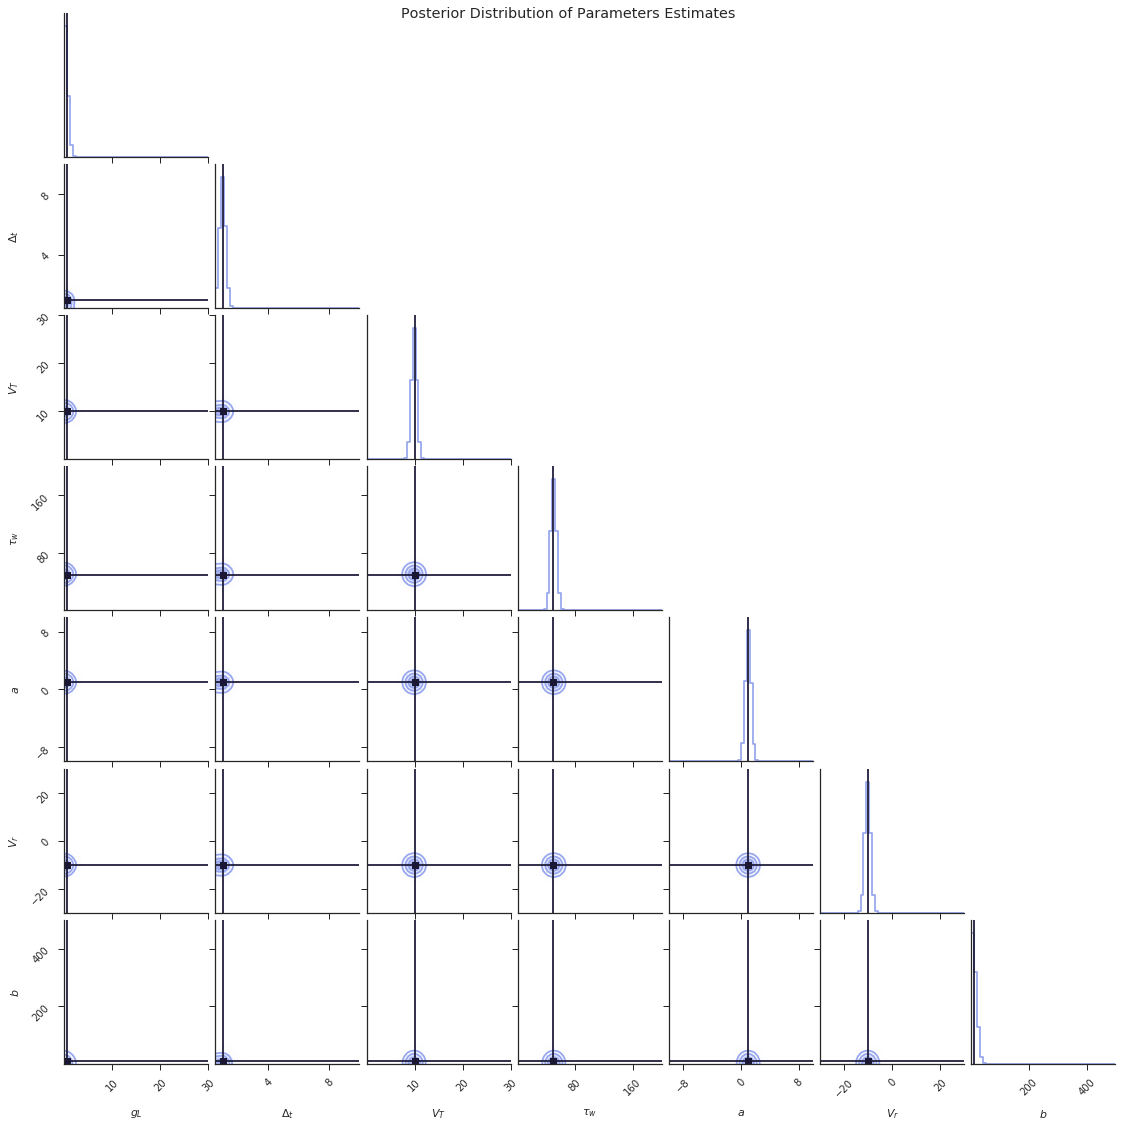

In [21]:
from corner import corner

figure(figsize=(8,8))
sns.set_style("ticks")

labs =  [r'$g_L$',r'$\Delta_t$',r'$V_T$',r'$\tau_w$',r'$a$',r'$V_r$','$b$']
c = corner(dstrf_smplr.flatchain[:,-7:],
        range=[[0,30],
               [0.5,10],
               [0,30],
               [1,200],
               [-10,10],
               [-30,30],
               [0,500]],
       bins=50, smooth=2,smooth1d=1,
       labels=labs,
       #plot_contours=False,
       truths=adexparam,
       color=ch4[3],max_n_ticks=3,truth_color=ch[0])

for i, a in enumerate(c.axes):
    
    if i%8 == 0:
        a.grid(0)
        #sns.despine(left=True)
        a.get_yaxis().set_visible(False)
    else:
        #a.grid()
        sns.despine()
suptitle("Posterior Distribution of Parameters Estimates")
savefig(figroot+"adex_corner.svg",bbox_inches='tight')

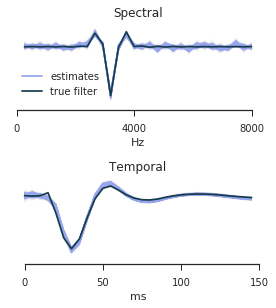

In [22]:
figure(figsize=(4,6))

sns.set_style("ticks")

chain = dstrf_smplr.flatchain

subplot(311)
title("Spectral")
x = np.arange(0,nspec)
plot(nfutils.normalize(chain[:,:-17].T)/6,color=ch4[3],alpha=0.005)
plot(nfutils.normalize(model.pstrf.sfilt.T)/6,ch4[3],label="estimates")
plot(nfutils.normalize(M.pstrf.sfilt.T)/6,ch4[0],label="true filter")
legend()


#yticks([])
title("Spectral")
xticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=45);
yticks([])
xlabel("Hz")

subplot(312)
title("Temporal")
x = np.arange(0,nspec)
plot(nfutils.normalize(fromt(chain[:,nspec:-7]).T)/4,color=ch4[3],alpha=0.005)
plot(nfutils.normalize(M.pstrf.tfilt.T)/4,ch4[0],label="true filter")
yticks([])
xticks([0,10,20,30],[0,50,100,150])
xlabel("ms")


sns.despine(offset=5,trim=True,left=True)
tight_layout()

savefig(figroot+"marg.svg",bbox_inches='tight')


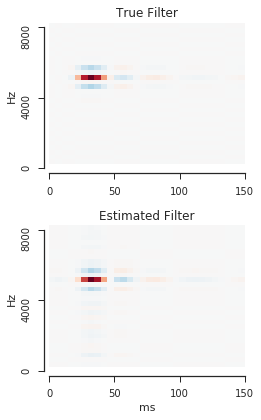

In [23]:
sns.set_style("ticks")

figure(figsize=(4,6))
model.set(np.mean(chain,0))

from neurofit import graphics

#figure()
subplot(211)
title("True Filter")
#graphics.strf_plot(M.k.sfilt,M.k.tfilt,0,8000,t_dsample)
sns.heatmap(M.pstrf.filt,cbar=False)

yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=45);
xticks([0,10,20,30],[0,50,100,150])
ylabel("Hz")


subplot(212)
title("Estimated Filter")
sns.heatmap(model.pstrf.filt,cbar=False)
yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=90);
xticks([0,10,20,30],[0,50,100,150])
xlabel("ms")
ylabel("Hz")

sns.despine(trim=True, offset=5)
tight_layout()

subplot(211)
yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=90);
subplot(212)
yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=90);


#graphics.strf_plot(model.k.sfilt,model.k.tfilt,0,8000,t_dsample)

savefig(figroot+"strf.svg",bbox_inches='tight')